In [2]:
%cd ..

/users/fzanetta/pyprojects/bernstein-flow


/scratch-shared/meteoswiss/scratch/fzanetta/mambaforge/envs/jax/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import typing as tp
import functools as ft

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from flax.experimental import nnx
import optax as ox
from jaxtyping import Float, Array
import scoringrules as sr

from bernstein_flow.distribution import BernsteinFlow
from swagp.data.preproc import Partitioner, Standardizer
from swagp.data.dataset import Dataset
from swagp._vscan import vscan

sr.register_backend("jax")

In [4]:
a = jnp.array([2.0])
b = jnp.array([-0.1])
theta = jnp.array([-2.5, 2, 3, -7, -7, -7, -7, -7, 7])
alpha = jnp.array([0.2])
beta = jnp.array([-2.50])
p = jnp.concatenate([a, b, theta, alpha, beta])
ps = p[None] + 0.2 * np.random.randn(32, *p.shape)
ps.shape


(32, 13)

(array([0.02420389, 0.        , 0.        , 0.02420389, 0.        ,
        0.        , 0.        , 0.        , 0.02420389, 0.        ,
        0.        , 0.        , 0.        , 0.02420389, 0.        ,
        0.        , 0.        , 0.02420385, 0.02420389, 0.02420385,
        0.07261167, 0.02420385, 0.09681556, 0.02420385, 0.07261167,
        0.04840778, 0.12101927, 0.12101944, 0.21783469, 0.14522333,
        0.21783484, 0.24203871, 0.26624259, 0.38726194, 0.29044646,
        0.3630582 , 0.38726194, 0.24203871, 0.43566976, 0.43566968,
        0.48407747, 0.43566972, 0.43566976, 0.31465033, 0.19363101,
        0.38726194, 0.24203871, 0.21783492, 0.24203871, 0.24203871,
        0.29044646, 0.26624259, 0.12101936, 0.19363097, 0.04840778,
        0.09681542, 0.19363111, 0.14522312, 0.31465055, 0.29044667,
        0.29044625, 0.29044667, 0.3146501 , 0.38726222, 0.41146552,
        0.43566937, 0.55668944, 0.62930111, 0.36305833, 0.41146611,
        0.65350311, 0.75032055, 0.75032055, 0.89

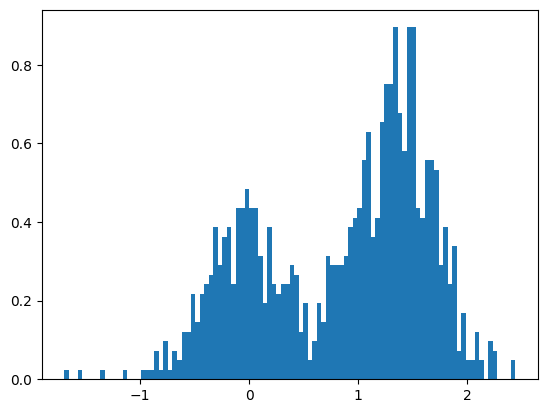

In [5]:
samples = BernsteinFlow(p[None]).sample(seed=0, sample_shape=(1000,))[:,0]
plt.hist(samples, bins=100, density=True)

[[-2.5892346  -0.49972963  2.881849    2.8828073   2.8841987   2.8852055
   2.88624     2.8871086  10.00915   ]
 [-2.049503    0.05791044  2.9065185   2.9074118   2.90879     2.9096406
   2.9107597   2.9120927   9.68921   ]
 [-2.337944   -0.23256278  2.9157853   2.9167018   2.9177246   2.918697
   2.9197693   2.920935   10.008218  ]
 [-2.1722836  -0.12502527  3.032251    3.033206    3.0344648   3.0354664
   3.0366132   3.0375896  10.102257  ]
 [-2.4771078  -0.49784493  2.6475692   2.6485333   2.649551    2.6506722
   2.6517525   2.6526468   9.89787   ]
 [-2.461604   -0.5239161   2.5109186   2.5119138   2.5133402   2.514527
   2.515373    2.51647     9.511     ]
 [-2.455514   -0.23604989  2.8910086   2.8920984   2.8929527   2.8937938
   2.8950653   2.8958447   9.652996  ]
 [-2.4759202  -0.3773086   2.6030874   2.6041343   2.6050282   2.6060116
   2.6069171   2.608093    9.291953  ]
 [-2.400111   -0.49767172  2.517211    2.5182605   2.5192351   2.5202513
   2.520981    2.521961    9.6730

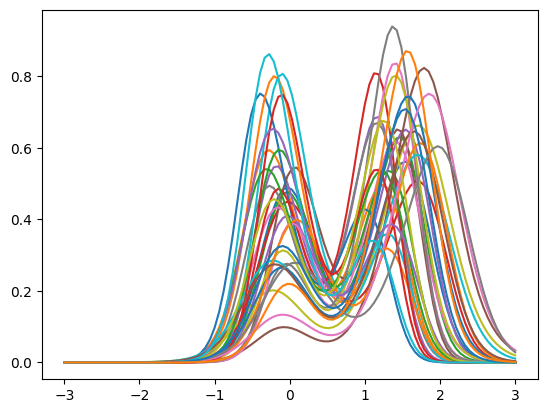

In [6]:
flow = BernsteinFlow(ps)
print(flow.bijector.bijector.bijectors[2].thetas)
x = jnp.linspace(-3, 3, 100)[:,None]
y_samples = flow.sample(seed=1, sample_shape=(2000,))
print(y_samples.shape)
plt.plot(x, flow.prob(x));

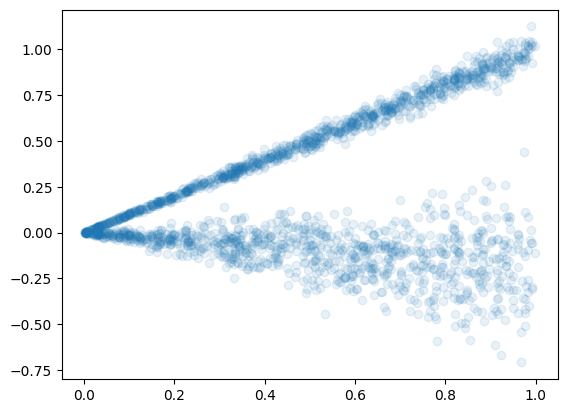

In [7]:
from sklearn.utils import shuffle

def gen_data(t):
    # x=1: y(t)=sin(t) + Normal(loc=0, scale=0.1*|y(t)|)
    t1=t
    y1=1.0*t1
    y1+=np.random.normal(0,0.05*np.abs(t1))
    
    # x=1: y(t)=-sin(t) + Normal(loc=0, scale=0.1*|y(t)|)
    t2=t
    y2=-.2*t2
    y2+=np.random.normal(0,0.2*np.abs(t2))
        
    t=np.concatenate([t1,t2])
    y=np.concatenate([y1,y2])

    return shuffle(t[...,np.newaxis], y[...,np.newaxis], random_state=0)

def gen_test_data(n=5, observations=100):
    t = np.linspace(0,1,n, dtype=np.float32)
    t=np.repeat([t],observations)

    return gen_data(t)

def gen_train_data(n=100):
    # x=1: y(t)=sin(t) + Normal(loc=0, scale=0.1*|y(t)|)
    t = np.random.uniform(0,1,n//2).astype(np.float32)
    
    return gen_data(t)

n = 2000
train_x,train_y = gen_train_data(n = n)
val_x, val_y = gen_train_data(n = n//10)
train_x.shape,train_y.shape, val_x.shape,val_y.shape

plt.scatter(train_x,train_y, alpha=0.1)

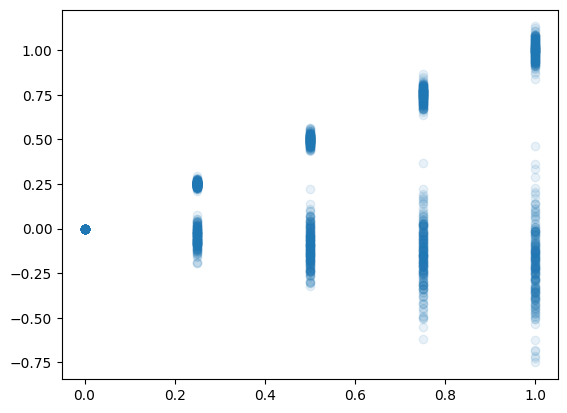

In [8]:
t_test, y_test = gen_test_data(5, 200)
x_test = np.unique(t_test)
plt.scatter(t_test, y_test, alpha=0.1)

In [9]:
def dataloader(x, y, batch_size, *, key, shuffle=True):
    dataset_size = x.shape[0]
    indices = jnp.arange(dataset_size)
    perm = indices
    while True:
        if shuffle:
            perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield jnp.array(x[batch_perm]), jnp.array(y[batch_perm])
            start = end
            end = start + batch_size


class BernsteinFlowRegressor(nnx.Module):
    def __init__(
        self,
        din: int,
        hidden: list[int],
        dout: int,
        *,
        key: jax.Array,
        aout: tp.Callable | None = None,
    ):
        h = [din] + hidden
        rngs = [nnx.Rngs(k) for k in jr.split(key, len(h))]
        self.hidden = [nnx.Linear(h[i], h[i + 1], rngs=rngs[i]) for i in range(len(h) - 1)]
        self.hidden = nnx.Sequence(self.hidden)
        self.out = nnx.Linear(hidden[-1], dout, rngs=rngs[-1])
        self.aout = aout
    
    def __call__(self, x: Float[Array, "... Din"]) -> Float[Array, "... Dout"]:
        for layer in self.hidden:
            x = layer(x)
            x = jax.nn.relu(x)
        return BernsteinFlow(self.out(x))
    
    def fit(
        self: tp.Self,
        x_train: Float[Array, "N Din"],
        y_train: Float[Array, "N Dout"],
        val_data: tuple[Float[Array, "N Din"], Float[Array, "N Dout"]],
        /,
        key: Array,
        opt: ox.GradientTransformation,
        *,
        batch_size: int = 32,
        n_steps: int = 400,
        verbose: bool = True,
    ) -> tuple[tp.Self, dict[str, Array]]:
        x_train, y_train = map(jnp.asarray, (x_train, y_train))
        val_data = tuple(map(jnp.asarray, val_data))

        train_dl = dataloader(
            x_train,
            y_train,
            batch_size=batch_size,
            key=key,
            shuffle=True,
        )

        params, moduledef = self.split()
        train_state = nnx.TrainState(
            moduledef,
            params=params,
            tx=opt,
        )

        iter_keys = jr.split(key, n_steps)

        def step(carry, key):
            key, _ = jr.split(key)
            carry, train_loss = self.train_step(carry, next(train_dl))
            log = self.val_step(carry, val_data)
            log["nll"] = train_loss
            return carry, log

        scan = vscan if verbose else jax.lax.scan
        train_state, history = scan(step, train_state, (iter_keys))
        model = moduledef.merge(train_state.params)

        return model, history

    @ft.partial(jax.jit, static_argnums=0)
    def train_step(self, state: nnx.TrainState, batch):
        x, y = batch
        y = y[..., 0]
        mask = ~jnp.isnan(y)
        # y = jnp.where(mask, y, 0.0)

        def loss_fn(params):
            flow, _ = state.apply(params)(x)
            flow: BernsteinFlow
            return jnp.mean(-flow.log_prob(y), where=mask)
        value, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, value

    @ft.partial(jax.jit, static_argnums=0)
    def val_step(self, state: nnx.TrainState, data):
        x, y = data
        flow, _ = state.apply("params")(x)
        crps = jnp.nanmean(-flow.log_prob(y[...,0]))
        return {"val_nll": crps}

  0%|          | 0/10000 [00:00<?, ?it/s]

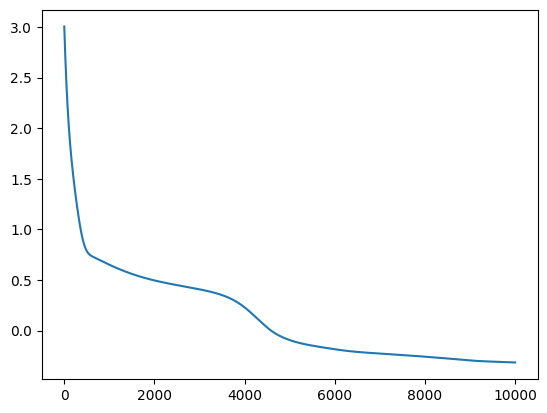

In [10]:
net = BernsteinFlowRegressor(1, [8], 16, key=jr.PRNGKey(0))

net, history = net.fit(
    train_x,
    train_y,
    (val_x, val_y),
    key=jr.PRNGKey(0),
    # opt=ox.sgd(0.01, momentum=0.9, nesterov=True),
    opt=ox.adam(0.001),
    batch_size=128,
    n_steps=10000,
)

plt.plot(history["val_nll"])

In [11]:
flow = net(x_test[:,None])
yy = jnp.linspace(-6, 6, 200)[:,None]
ps = flow.prob(yy)

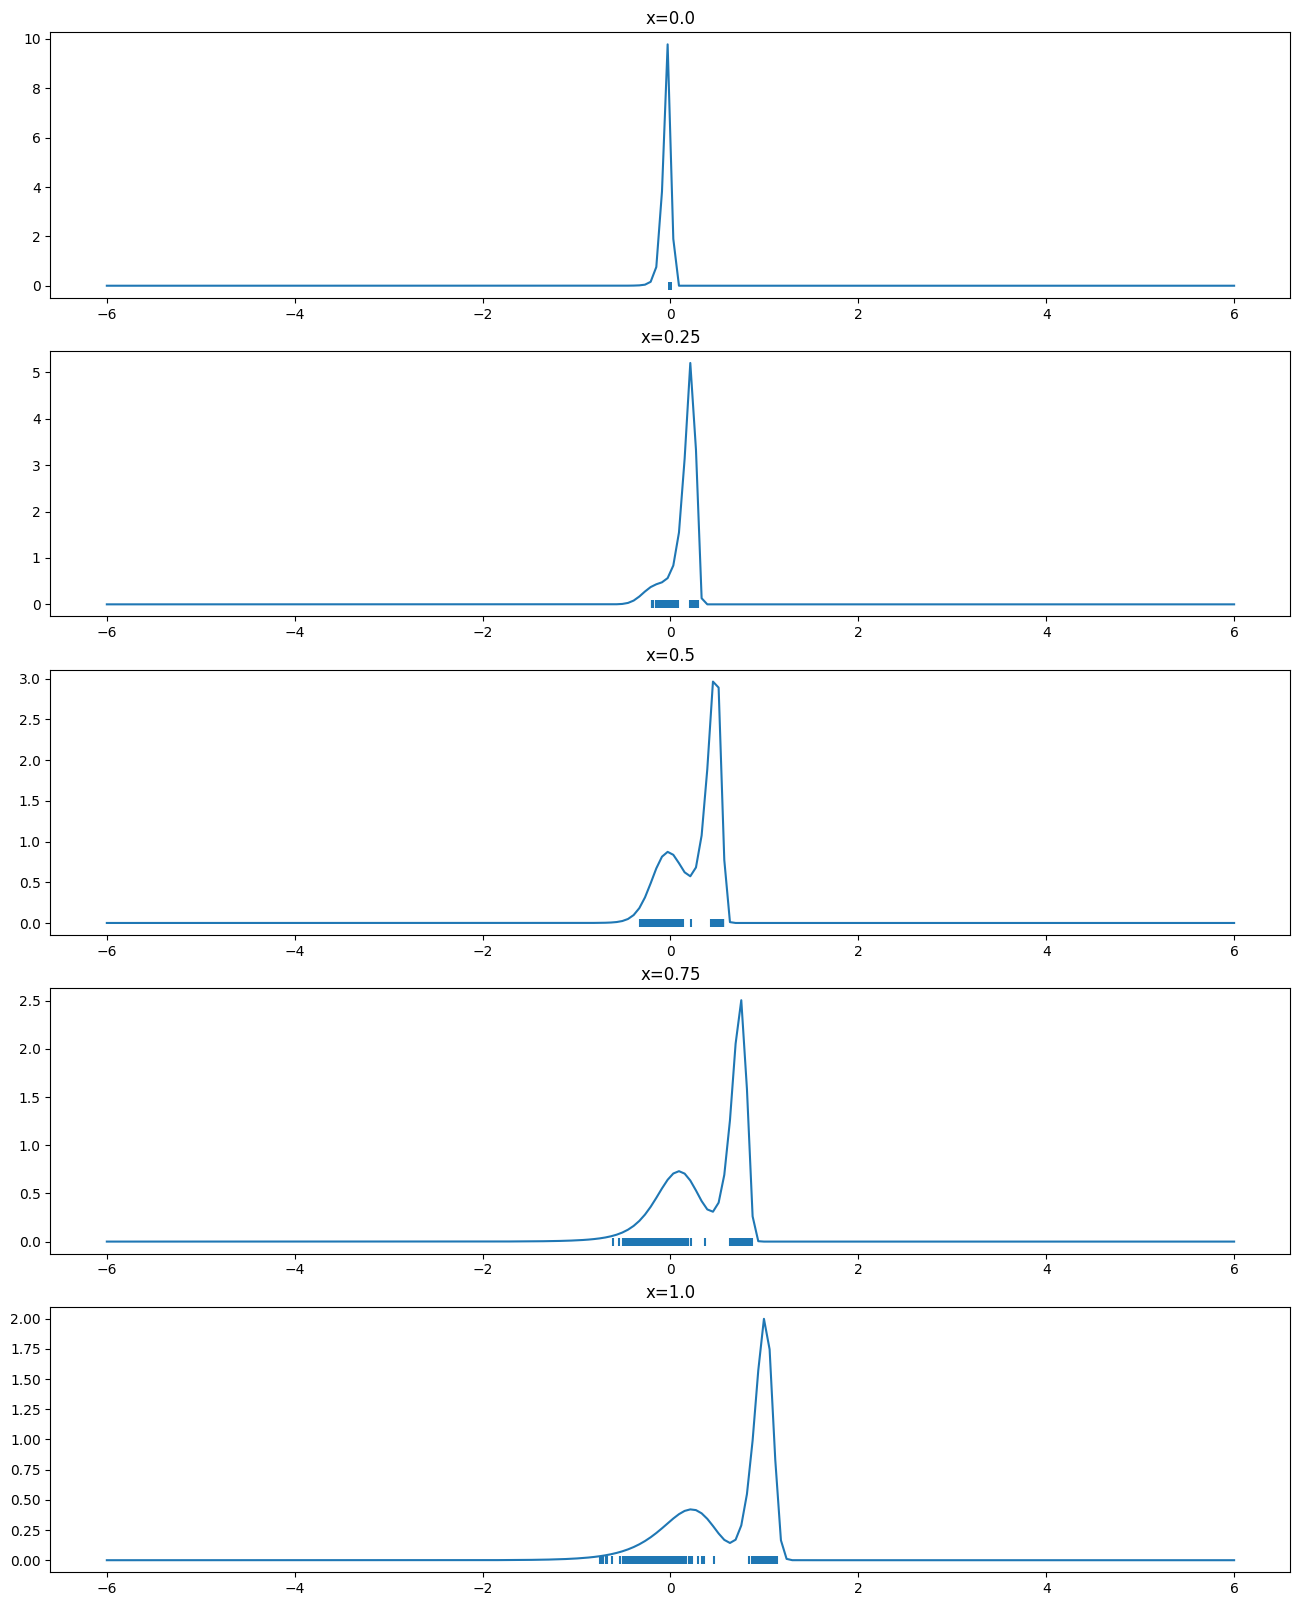

In [12]:
fig, ax = plt.subplots(len(x_test), figsize=(16, len(x_test)*4))
for i,x in enumerate(x_test):
    ax[i].set_title(f'x={x}')
    sampl=y_test[(t_test.flatten()==x)].flatten()
    ax[i].scatter(sampl, [0]*len(sampl), marker='|')
    #ax[i].hist(sampl, bins=30, density=True)
    ax[i].plot(yy,ps[:,i])

(array([346.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   2.,   2.,   2.,   2.,   2.,   3.,   1.,   3.,  11.,
         15.,  25.,  29.,  33.,  67.,  75.,  79.,  95.,  81.,  72.,  49.,
         38.,  39., 153., 347., 329.,  98.]),
 array([-4.06620455, -3.96073985, -3.85527515, -3.74981046, -3.64434576,
        -3.53888106, -3.43341637, -3.32795167, -3.22248697, -3.11702204,
        -3.01155734, -2.90609264, -2.80062795, -2.69516325, -2.58969855,
        -2.48423386, -2.37876916, -2.27330446, -2.16783977, -2.06237507,
        -1.95691037, -1.85144556, -1.74598086, -1.64051616, -1.53505147,
        -1.42958677, -1.32412207, -1.21865737, -1.11319268, -1.00772798,
        -0.90226322, -0.79679853, -0.69133377, -0.58586907, -0.48040438,
        -0.37493965, -0.26947495, -0.16401023, -0.05854552,  0.04691919,
         0.15238389,  0.25784862,  0.36331332,  0.46877804,  0.57424277,
 

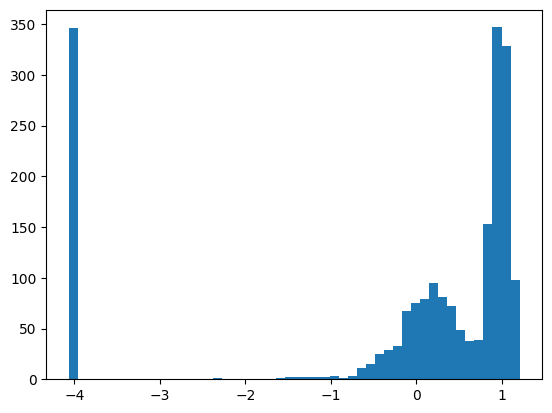

In [13]:
samples = flow.sample(seed=1, sample_shape=(2000,))
plt.hist(samples[:,-1], bins=50)

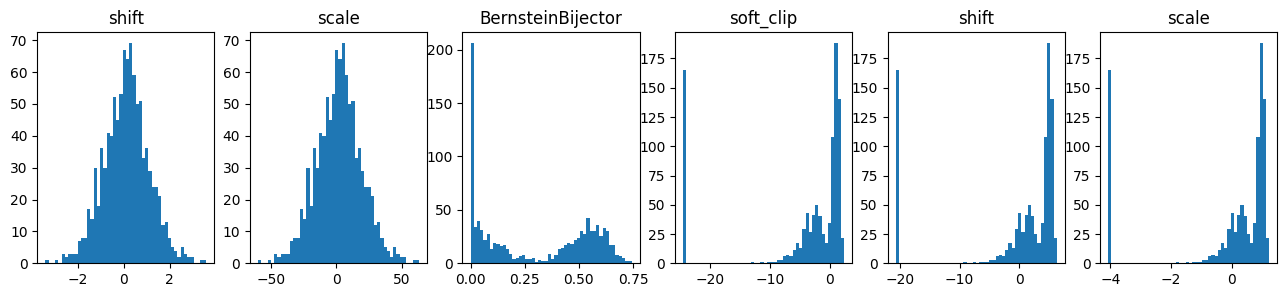

In [25]:
x = np.random.randn(1000,1)
bijectors = flow.bijector.bijector.bijectors
fig, ax = plt.subplots(1, len(bijectors), figsize=(16, 3))
for i, bj in enumerate(flow.bijector.bijector.bijectors):
    x = bj.inverse(x)
    ax[i].hist(np.array(x[:,-1]).ravel(), bins=50)
    ax[i].set_title(bj.name)

In [118]:
features = [
    "weather:wind_speed_of_gust",
    "weather:wind_speed_of_gust_p1h",
    "weather:wind_speed_of_gust_m1h",
    "weather:sx_500m",
    "time:sin_hourofday",
    "time:cos_hourofday",
    "static:elevation",
    "static:tpi_500m",
    "static:tpi_2000m",
    "static:model_elevation_difference",
    "static:we_derivative_2000m",
    "static:sn_derivative_2000m",
]

target = ["weather:wind_speed_of_gust"]
x = xr.open_zarr("../swagp/data/x.zarr")[features].isel(time=slice(1,-1))
y = xr.open_zarr("../swagp/data/y.zarr")[target].isel(time=slice(1,-1))

seed = 42

# preprocessing: partition, standardize & (optionally) transform
partitioner = Partitioner(y[target[0]], seed=seed)
data = {p: partitioner.get(x, y, p=p) for p in ["train", "val_target"]}

standardizer = Standardizer.fit(data["train"][0], dims=("time","station"))
# standardizer.scale["static:easting"].values = standardizer.scale["static:northing"].values
for k, v in data.items():
    data[k][0] = standardizer.transform(v[0])

train = Dataset.from_xarray(*data["train"])
val_target = Dataset.from_xarray(*data["val_target"])


In [119]:
def dataloader(x, y, batch_size, *, key, shuffle=True):
    dataset_size = x.shape[0]
    indices = jnp.arange(dataset_size)
    perm = indices
    while True:
        if shuffle:
            perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield jnp.array(x[batch_perm]), jnp.array(y[batch_perm])
            start = end
            end = start + batch_size

In [409]:

class NeuralNetworkTraining(nnx.Module):
    def fit(
        self: tp.Self,
        x_train: Float[Array, "N Din"],
        y_train: Float[Array, "N Dout"],
        val_data: tuple[Float[Array, "N Din"], Float[Array, "N Dout"]],
        /,
        key: Array,
        opt: ox.GradientTransformation,
        *,
        batch_size: int = 32,
        n_steps: int = 400,
        verbose: bool = True,
    ) -> tuple[tp.Self, dict[str, Array]]:
        x_train, y_train = map(jnp.asarray, (x_train, y_train))
        val_data = tuple(map(jnp.asarray, val_data))

        train_dl = dataloader(
            x_train,
            y_train,
            batch_size=batch_size,
            key=key,
            shuffle=True,
        )

        params, moduledef = self.split()
        train_state = nnx.TrainState(
            moduledef,
            params=params,
            tx=opt,
        )

        iter_keys = jr.split(key, n_steps)

        def step(carry, key):
            key, _ = jr.split(key)
            carry, train_loss = self.train_step(carry, next(train_dl))
            log = self.val_step(carry, val_data)
            log["crps"] = train_loss
            return carry, log

        scan = vscan if verbose else jax.lax.scan
        train_state, history = scan(step, train_state, (iter_keys))
        model = moduledef.merge(train_state.params)

        return model, history

    @ft.partial(jax.jit, static_argnums=0)
    def train_step(self, state: nnx.TrainState, batch):
        x, y = batch
        y = y[..., 0]
        mask = ~jnp.isnan(y)
        y = jnp.where(mask, y, 0.0)

        def loss_fn(params):
            y_pred, _ = state.apply(params)(x)
            loss = sr.crps_normal(y_pred[...,0], y_pred[...,1], y, backend="jax")
            return jnp.mean(loss, where=mask)

        value, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, value

    @ft.partial(jax.jit, static_argnums=0)
    def val_step(self, state: nnx.TrainState, data):
        x, y = data
        y_pred, _ = state.apply("params")(x)
        crps = jnp.nanmean(sr.crps_normal(y_pred[...,0], y_pred[...,1], y[..., 0], backend="jax"))
        return {"val_crps": crps}
    

class NeuralNetworkTraining(nnx.Module):
    def fit(
        self: tp.Self,
        x_train: Float[Array, "N Din"],
        y_train: Float[Array, "N Dout"],
        val_data: tuple[Float[Array, "N Din"], Float[Array, "N Dout"]],
        /,
        key: Array,
        opt: ox.GradientTransformation,
        *,
        batch_size: int = 32,
        n_steps: int = 400,
        verbose: bool = True,
    ) -> tuple[tp.Self, dict[str, Array]]:
        x_train, y_train = map(jnp.asarray, (x_train, y_train))
        val_data = tuple(map(jnp.asarray, val_data))

        train_dl = dataloader(
            x_train,
            y_train,
            batch_size=batch_size,
            key=key,
            shuffle=True,
        )

        params, moduledef = self.split()
        train_state = nnx.TrainState(
            moduledef,
            params=params,
            tx=opt,
        )

        iter_keys = jr.split(key, n_steps)

        def step(carry, key):
            key, _ = jr.split(key)
            carry, train_loss = self.train_step(carry, next(train_dl))
            log = self.val_step(carry, val_data)
            log["crps"] = train_loss
            return carry, log

        scan = vscan if verbose else jax.lax.scan
        train_state, history = scan(step, train_state, (iter_keys))
        model = moduledef.merge(train_state.params)

        return model, history

    @ft.partial(jax.jit, static_argnums=0)
    def train_step(self, state: nnx.TrainState, batch):
        x, y = batch
        y = y[..., 0]
        mask = ~jnp.isnan(y)
        y = jnp.where(mask, y, 0.0)

        def loss_fn(params):
            y_pred, _ = state.apply(params)(x)
            loss = sr.crps_normal(y_pred[...,0], y_pred[...,1], y, backend="jax")
            return jnp.mean(loss, where=mask)

        value, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, value

    @ft.partial(jax.jit, static_argnums=0)
    def val_step(self, state: nnx.TrainState, data):
        x, y = data
        y_pred, _ = state.apply("params")(x)
        crps = jnp.nanmean(sr.crps_normal(y_pred[...,0], y_pred[...,1], y[..., 0], backend="jax"))
        return {"val_crps": crps}
    
    
class MLP(NeuralNetworkTraining, nnx.Module):
    def __init__(
        self,
        din: int,
        hidden: list[int],
        dout: int,
        *,
        key: jax.Array,
        aout: tp.Callable | None = None,
    ):
        h = [din] + hidden
        rngs = [nnx.Rngs(k) for k in jr.split(key, len(h))]
        self.hidden = [nnx.Linear(h[i], h[i + 1], rngs=rngs[i]) for i in range(len(h) - 1)]
        self.hidden = nnx.Sequence(self.hidden)
        self.out = nnx.Linear(hidden[-1], dout, rngs=rngs[-1])
        self.aout = aout

    def __call__(self, x: Float[Array, "... Din"]) -> Float[Array, "... Dout"]:
        for layer in self.hidden:
            x = layer(x)
            x = jax.nn.relu(x)
        return self.aout(self.out(x)) if self.aout else self.out(x)
    

class BernsteinFlowRegressor(MLP):

    def __call__(self, x: Float[Array, "... Din"]) -> Float[Array, "... Dout"]:
        for layer in self.hidden:
            x = layer(x)
            x = jax.nn.relu(x)
        return BernsteinFlow(self.out(x))

    @ft.partial(jax.jit, static_argnums=0)
    def train_step(self, state: nnx.TrainState, batch):
        x, y = batch
        y = y[..., 0]
        mask = ~jnp.isnan(y)
        y = jnp.where(mask, y, 0.0)

        def loss_fn(params):
            flow, _ = state.apply(params)(x)
            flow: BernsteinFlow
            
            # samples = flow.sample(seed=state.step[None].astype(jnp.uint32).repeat(2), sample_shape=(51,))
            # loss = sr.crps_ensemble(samples, y, axis=0, backend="jax")
            return jnp.mean(-flow.log_prob(y), where=mask)
        # def loss_fn(params):
        #     flow, _ = state.apply(params)(x)
        #     loss = sr.crps_normal(0.0, 1.0, flow.bijector.forward(y), backend="jax")
        #     return jnp.mean(loss, where=mask)

        value, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, value

    @ft.partial(jax.jit, static_argnums=0)
    def val_step(self, state: nnx.TrainState, data):
        x, y = data
        flow, _ = state.apply("params")(x)
        # samples = flow.sample(seed=state.step[None].astype(jnp.uint32).repeat(2), sample_shape=(51,))
        # crps = jnp.nanmean(sr.crps_ensemble(samples, y, axis=0, backend="jax"))
        crps = jnp.nanmean(-flow.log_prob(y))
        return {"val_crps": crps}


# net = MLP(
#     din=train.x.shape[-1],
#     hidden=[32, 32],
#     dout=2,
#     key=jr.PRNGKey(42),
#     aout=jax.nn.softplus,
# )

net = BernsteinFlowRegressor(
    din=train.x.shape[-1],
    hidden=[32, 32],
    dout=9,
    key=jr.PRNGKey(42),
    aout=None,

)
net, history = net.fit(
    train.x.reshape(-1, len(features)),
    train.y.reshape(-1, len(target)),
    (val_target.x.reshape(-1, len(features))[::30], val_target.y.reshape(-1, len(target))[::30]),
    key=jr.PRNGKey(42),
    opt=ox.adam(1e-3),
    batch_size=2 ** 9,
    n_steps=200,
)

plt.plot(history["val_crps"])

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:

class NeuralNetworkTraining(nnx.Module):
    def fit(
        self: tp.Self,
        x_train: Float[Array, "N Din"],
        y_train: Float[Array, "N Dout"],
        val_data: tuple[Float[Array, "N Din"], Float[Array, "N Dout"]],
        /,
        key: Array,
        opt: ox.GradientTransformation,
        *,
        batch_size: int = 32,
        n_steps: int = 400,
        verbose: bool = True,
    ) -> tuple[tp.Self, dict[str, Array]]:
        x_train, y_train = map(jnp.asarray, (x_train, y_train))
        val_data = tuple(map(jnp.asarray, val_data))

        train_dl = dataloader(
            x_train,
            y_train,
            batch_size=batch_size,
            key=key,
            shuffle=True,
        )

        params, moduledef = self.split()
        train_state = nnx.TrainState(
            moduledef,
            params=params,
            tx=opt,
        )

        iter_keys = jr.split(key, n_steps)

        def step(carry, key):
            key, _ = jr.split(key)
            carry, train_loss = self.train_step(carry, next(train_dl))
            log = self.val_step(carry, val_data)
            log["crps"] = train_loss
            return carry, log

        scan = vscan if verbose else jax.lax.scan
        train_state, history = scan(step, train_state, (iter_keys))
        model = moduledef.merge(train_state.params)

        return model, history

    @ft.partial(jax.jit, static_argnums=0)
    def train_step(self, state: nnx.TrainState, batch):
        x, y = batch
        y = y[..., 0]
        mask = ~jnp.isnan(y)
        y = jnp.where(mask, y, 0.0)

        def loss_fn(params):
            y_pred, _ = state.apply(params)(x)
            loss = sr.crps_normal(y_pred[...,0], y_pred[...,1], y, backend="jax")
            return jnp.mean(loss, where=mask)

        value, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, value

    @ft.partial(jax.jit, static_argnums=0)
    def val_step(self, state: nnx.TrainState, data):
        x, y = data
        y_pred, _ = state.apply("params")(x)
        crps = jnp.nanmean(sr.crps_normal(y_pred[...,0], y_pred[...,1], y[..., 0], backend="jax"))
        return {"val_crps": crps}
    

class NeuralNetworkTraining(nnx.Module):
    def fit(
        self: tp.Self,
        x_train: Float[Array, "N Din"],
        y_train: Float[Array, "N Dout"],
        val_data: tuple[Float[Array, "N Din"], Float[Array, "N Dout"]],
        /,
        key: Array,
        opt: ox.GradientTransformation,
        *,
        batch_size: int = 32,
        n_steps: int = 400,
        verbose: bool = True,
    ) -> tuple[tp.Self, dict[str, Array]]:
        x_train, y_train = map(jnp.asarray, (x_train, y_train))
        val_data = tuple(map(jnp.asarray, val_data))

        train_dl = dataloader(
            x_train,
            y_train,
            batch_size=batch_size,
            key=key,
            shuffle=True,
        )

        params, moduledef = self.split()
        train_state = nnx.TrainState(
            moduledef,
            params=params,
            tx=opt,
        )

        iter_keys = jr.split(key, n_steps)

        def step(carry, key):
            key, _ = jr.split(key)
            carry, train_loss = self.train_step(carry, next(train_dl))
            log = self.val_step(carry, val_data)
            log["crps"] = train_loss
            return carry, log

        scan = vscan if verbose else jax.lax.scan
        train_state, history = scan(step, train_state, (iter_keys))
        model = moduledef.merge(train_state.params)

        return model, history

    @ft.partial(jax.jit, static_argnums=0)
    def train_step(self, state: nnx.TrainState, batch):
        x, y = batch
        y = y[..., 0]
        mask = ~jnp.isnan(y)
        y = jnp.where(mask, y, 0.0)

        def loss_fn(params):
            y_pred, _ = state.apply(params)(x)
            loss = sr.crps_normal(y_pred[...,0], y_pred[...,1], y, backend="jax")
            return jnp.mean(loss, where=mask)

        value, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, value

    @ft.partial(jax.jit, static_argnums=0)
    def val_step(self, state: nnx.TrainState, data):
        x, y = data
        y_pred, _ = state.apply("params")(x)
        crps = jnp.nanmean(sr.crps_normal(y_pred[...,0], y_pred[...,1], y[..., 0], backend="jax"))
        return {"val_crps": crps}
    
    
class MLP(NeuralNetworkTraining, nnx.Module):
    def __init__(
        self,
        din: int,
        hidden: list[int],
        dout: int,
        *,
        key: jax.Array,
        aout: tp.Callable | None = None,
    ):
        h = [din] + hidden
        rngs = [nnx.Rngs(k) for k in jr.split(key, len(h))]
        self.hidden = [nnx.Linear(h[i], h[i + 1], rngs=rngs[i]) for i in range(len(h) - 1)]
        self.hidden = nnx.Sequence(self.hidden)
        self.out = nnx.Linear(hidden[-1], dout, rngs=rngs[-1])
        self.aout = aout

    def __call__(self, x: Float[Array, "... Din"]) -> Float[Array, "... Dout"]:
        for layer in self.hidden:
            x = layer(x)
            x = jax.nn.relu(x)
        return self.aout(self.out(x)) if self.aout else self.out(x)
    

class BernsteinFlowRegressor(MLP):

    def __call__(self, x: Float[Array, "... Din"]) -> Float[Array, "... Dout"]:
        for layer in self.hidden:
            x = layer(x)
            x = jax.nn.relu(x)
        return BernsteinFlow(self.out(x))

    @ft.partial(jax.jit, static_argnums=0)
    def train_step(self, state: nnx.TrainState, batch):
        x, y = batch
        y = y[..., 0]
        mask = ~jnp.isnan(y)
        y = jnp.where(mask, y, 0.0)

        def loss_fn(params):
            flow, _ = state.apply(params)(x)
            flow: BernsteinFlow
            
            # samples = flow.sample(seed=state.step[None].astype(jnp.uint32).repeat(2), sample_shape=(51,))
            # loss = sr.crps_ensemble(samples, y, axis=0, backend="jax")
            return jnp.mean(-flow.log_prob(y), where=mask)
        # def loss_fn(params):
        #     flow, _ = state.apply(params)(x)
        #     loss = sr.crps_normal(0.0, 1.0, flow.bijector.forward(y), backend="jax")
        #     return jnp.mean(loss, where=mask)

        value, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, value

    @ft.partial(jax.jit, static_argnums=0)
    def val_step(self, state: nnx.TrainState, data):
        x, y = data
        flow, _ = state.apply("params")(x)
        # samples = flow.sample(seed=state.step[None].astype(jnp.uint32).repeat(2), sample_shape=(51,))
        # crps = jnp.nanmean(sr.crps_ensemble(samples, y, axis=0, backend="jax"))
        crps = jnp.nanmean(-flow.log_prob(y))
        return {"val_crps": crps}


# net = MLP(
#     din=train.x.shape[-1],
#     hidden=[32, 32],
#     dout=2,
#     key=jr.PRNGKey(42),
#     aout=jax.nn.softplus,
# )

net = BernsteinFlowRegressor(
    din=train.x.shape[-1],
    hidden=[32, 32],
    dout=9,
    key=jr.PRNGKey(42),
    aout=None,

)
net, history = net.fit(
    train.x.reshape(-1, len(features)),
    train.y.reshape(-1, len(target)),
    (val_target.x.reshape(-1, len(features))[::30], val_target.y.reshape(-1, len(target))[::30]),
    key=jr.PRNGKey(42),
    opt=ox.adam(1e-3),
    batch_size=2 ** 9,
    n_steps=200,
)

plt.plot(history["val_crps"])

  0%|          | 0/200 [00:00<?, ?it/s]

In [407]:
pred_flow = net(val_target.x[[-19],8])
pred_flow

Array([[6.2320323, 2.7660766]], dtype=float32)

In [408]:
val_target.y[[-19],8]

array([[7.7]], dtype=float32)

(array([ 20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   3.,   2.,  11.,
         10.,  40.,  82., 161., 184., 220., 128.,  43.,  29.,   7.,   5.,
          0.,   4.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  49.]),
 array([-4.69022064e+01, -4.49493713e+01, -4.29965324e+01, -4.10436974e+01,
        -3.90908623e+01, -3.71380234e+01, -3.51851883e+01, -3.32323532e+01,
        -3.12795162e+01, -2.93266792e+01, -2.73738441e+01, -2.54210072e+01,
        -2.34681702e+01, -2.15153351e+01, -1.95624981e+01, -1.76096611e+01,
        -1.56568260e+01, -1.37039890e+01, -1.17511530e+01, -9.79831696e+00,
        -7.84548044e+00, -5.89264393e+00, -3.93980765e+00, -1.98697138e+00,
        -3.41351330e-02,  1.91870117e+00,  3.87153745e+00,  5.82437372e+00,
         7.77721024e+00,  9.73004627e+00,  1.16828823e+01,  1.36357193e+01,
         1.55885553e+01,  1.75413914e+01,  1.94942

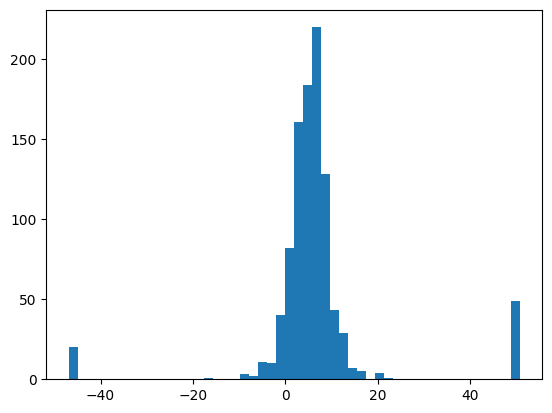

In [403]:
plt.hist(np.asarray(y_samples).ravel(), bins=50)

(array([101.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   3.,
          0.,   2.,   6.,   3.,   5.,   6.,  11.,  13.,  20.,  25.,  45.,
         81., 123., 166., 194., 147.,  47.]),
 array([-7.19695282, -7.05763245, -6.91831255, -6.77899218, -6.6396718 ,
        -6.50035191, -6.36103153, -6.22171116, -6.08239126, -5.94307089,
        -5.80375051, -5.66443062, -5.52511024, -5.38578987, -5.24646997,
        -5.1071496 , -4.96782923, -4.82850933, -4.68918896, -4.54986858,
        -4.41054869, -4.27122831, -4.13190794, -3.9925878 , -3.85326767,
        -3.7139473 , -3.57462716, -3.43530703, -3.29598665, -3.15666652,
        -3.01734638, -2.87802601, -2.73870587, -2.59938574, -2.46006536,
        -2.32074523, -2.18142509, -2.04210472, -1.90278459, -1.76346433,
        -1.62414408, -1.48482394, -1.34550369, -1.20618343, -1.0668633 ,
 

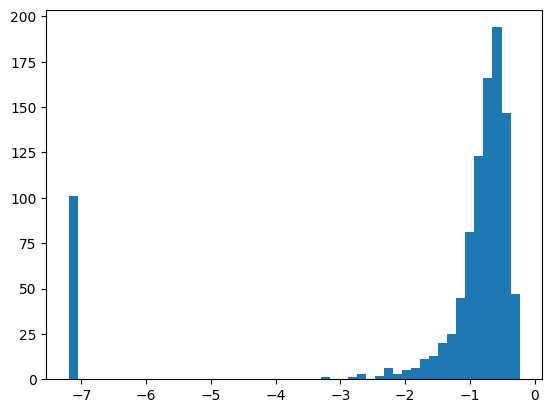

In [316]:
plt.hist(np.asarray(pred_flow.sample(seed=43, sample_shape=(1000,))).ravel(), bins=50)

In [317]:
pred_flow = net(val_target.x[[-800],8])
print(pred_flow.bijector.bijector.bijectors[0].shift)
print(pred_flow.bijector.bijector.bijectors[1].scale)
print(pred_flow.bijector.bijector.bijectors[2].thetas)
print(pred_flow.bijector.bijector.bijectors[3])
print(pred_flow.bijector.bijector.bijectors[4].shift)
print(pred_flow.bijector.bijector.bijectors[5].scale)

[-0.44302312]
[3.0026746]
[[-1.1280738  -0.3791805   0.08123931  1.2031236   3.018198    3.89233
   5.1533713   6.46261   ]]
[0.14139555]
[3.511997]


In [329]:
pred_flow.bijector.bijector.bijectors[0].shift *= 1
pred_flow.bijector.bijector.bijectors[1].scale *= 1
pred_flow.bijector.bijector.bijectors[4].shift *= 1
pred_flow.bijector.bijector.bijectors[5].scale *= -1

print(pred_flow.bijector.bijector.bijectors[0].shift)
print(pred_flow.bijector.bijector.bijectors[1].scale)
print(pred_flow.bijector.bijector.bijectors[2].thetas)
print(pred_flow.bijector.bijector.bijectors[3])
print(pred_flow.bijector.bijector.bijectors[4].shift)
print(pred_flow.bijector.bijector.bijectors[5].scale)

[0.44302312]
[3.0026746]
[[-1.1280738  -0.3791805   0.08123931  1.2031236   3.018198    3.89233
   5.1533713   6.46261   ]]
[0.14139555]
[-3.511997]


(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  1.,  0.,  2.,  2.,  3.,  3.,  6.,  4.,  4.,  3.,  9.,
         5., 20., 13., 22., 29., 31., 30., 42., 49., 70., 68., 81., 77.,
        61., 70., 60., 66., 64., 30., 27., 20.,  9.,  9.,  6.]),
 array([-1.15765464, -1.13520384, -1.11275303, -1.09030223, -1.06785142,
        -1.04540062, -1.02294981, -1.00049901, -0.97804821, -0.9555974 ,
        -0.9331466 , -0.91069579, -0.88824499, -0.86579418, -0.84334338,
        -0.82089257, -0.79844177, -0.77599096, -0.75354016, -0.73108935,
        -0.70863855, -0.68618774, -0.66373694, -0.64128613, -0.61883533,
        -0.59638453, -0.57393372, -0.55148292, -0.52903211, -0.50658131,
        -0.48413047, -0.46167967, -0.43922886, -0.41677806, -0.39432725,
        -0.37187645, -0.34942564, -0.32697484, -0.30452403, -0.28207323,
        -0.25962242, -0.23717162, -0.21472082, -0.19227001, -0.16981921,
        -0.1473684 , -0.1249176 , -0.10246679, -0.08001599,

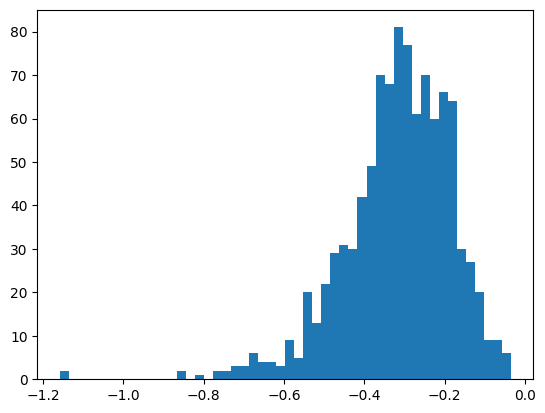

In [331]:
plt.hist(np.asarray(pred_flow.sample(seed=43, sample_shape=(1000,))).ravel(), bins=50)

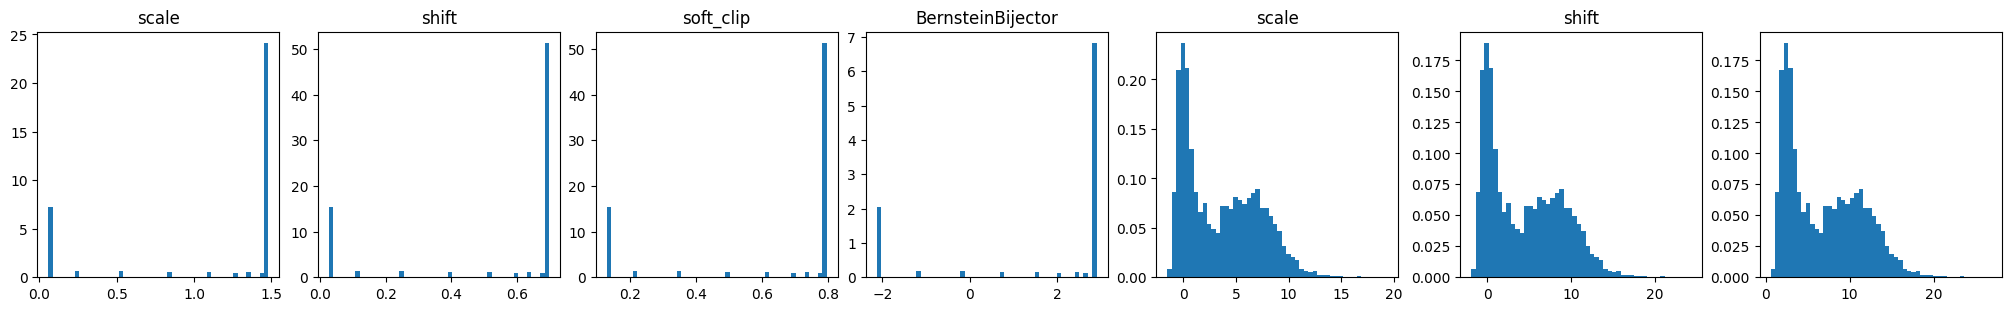

In [385]:
y = np.array(val_target.y[:,0])

a = jnp.array([-2.0])
b = jnp.array([-1.0])
theta = jnp.array([-2.13, -0.27, 2.88, 2.885, 2.89, 2.895, 2.90])
alpha = jnp.array([-2.0])
beta = jnp.array([-10.0])
p = jnp.concatenate([a, b, theta, alpha, beta])

flow = BernsteinFlow(p[None], constrained=True)

fig, axs = plt.subplots(1, 7, layout="constrained", figsize=(20, 3))
axs[-1].hist(np.asarray(y).ravel(), bins=50, density=True)
for i, bj in enumerate(flow.bijector.bijector.bijectors):
    y = bj.forward(y)
    axs[-(i+1)-1].hist(np.asarray(y).ravel(), bins=50, density=True)
    axs[-(i+1)-1].set_title(bj.name)

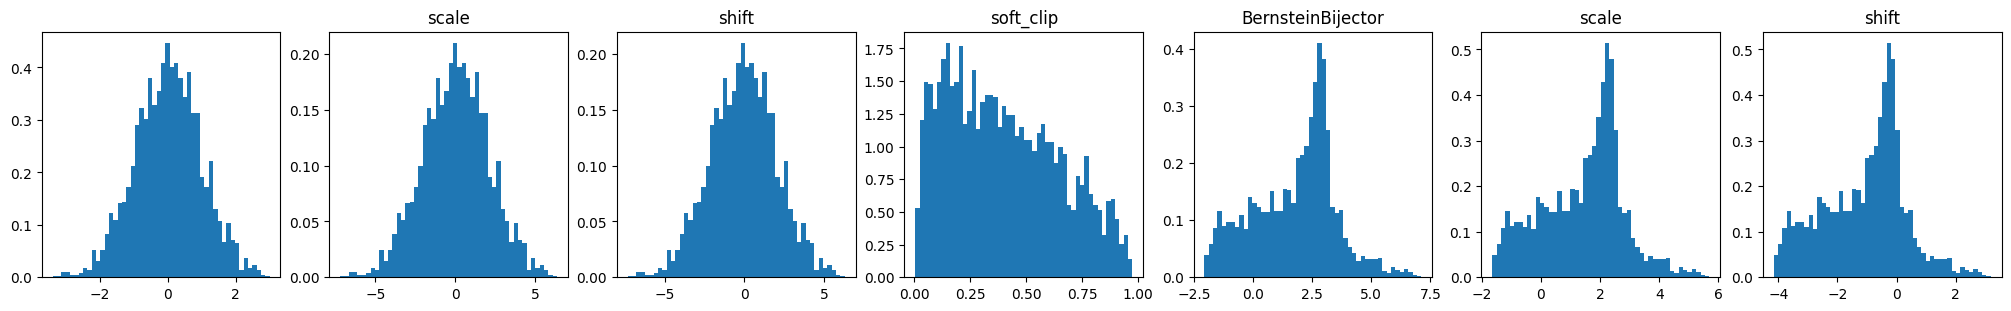

In [389]:
y = np.random.randn(3000)

a = jnp.array([2.0])
b = jnp.array([-0.1])
theta = jnp.array([-2.13, -0.27, 2.88, 2.885, 2.89, 2.895, 2.90, 8.0])
# theta = jnp.array([-2.5, 2, 3, -7, -7, -7, -7, -7, 7])
alpha = jnp.array([0.2])
beta = jnp.array([-2.50])
p = jnp.concatenate([a, b, theta, alpha, beta])

flow = BernsteinFlow(p[None], constrained=True)

fig, axs = plt.subplots(1, 7, layout="constrained", figsize=(20, 3))
axs[0].hist(np.asarray(y).ravel(), bins=50, density=True)
for i, bj in enumerate(flow.bijector.bijector.bijectors[::-1]):
    y = bj.forward(y)
    axs[i+1].hist(np.asarray(y).ravel(), bins=50, density=True)
    axs[i+1].set_title(bj.name)

(array([   16.,    27.,    63.,     0.,     0.,    53.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10356.]),
 array([ 4.96895313,  5.32335567,  5.67775822,  6.03216076,  6.3865633 ,
         6.74096537,  7.09536791,  7.44977045,  7.80417299,  8.15857506,
         8.5129776 ,  8.86738014,  9.22178268,  9.57618523,  9.93058777,
        10.28499031, 10.63939285, 10.99379539, 11.34819794, 11.70260048,
        12.05700302, 12.41140556, 12.76580811, 13.12021065, 13.47461319,
        13.82901573, 14.18341732, 14.53781986, 14.8922224 , 15.24662495,
        15.60102749, 15.95543003, 16.30983353, 16.66423607, 17.0186367 ,
        17.37303925, 17.7274417

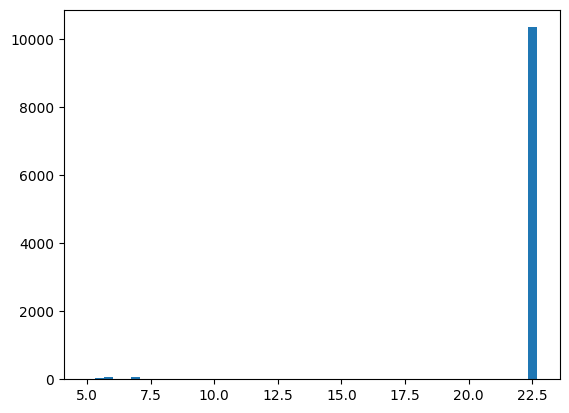

In [294]:
plt.hist(np.asarray(flow.bijector.forward(val_target.y.reshape(-1, 1)[::100])).ravel(), bins=50)

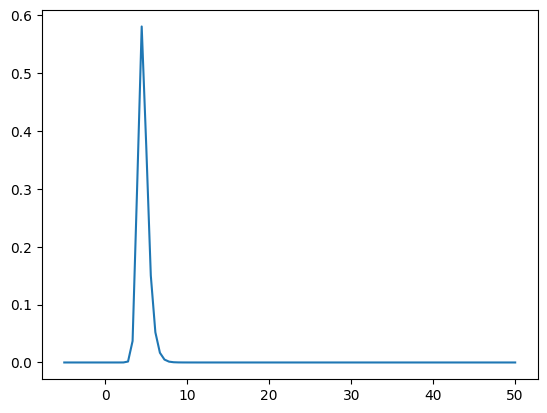

In [290]:
a = jnp.array([1.0])
b = jnp.array([-5.0])
theta = jnp.array([-2.5, 2, 3, -7, -6])
alpha = jnp.array([1.0])
beta = jnp.array([-2.50])
p = jnp.concatenate([a, b, theta, alpha, beta])

flow = BernsteinFlow(p[None])

wind_values = jnp.linspace(-5, 50, 100)
plt.plot(wind_values, flow.prob(wind_values))